In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import json
import pathlib

plt.rcParams['figure.figsize'] = (7, 3.5)

In [2]:
asm_parameters = {
     'saxpy_avx_x1': {
        'loop_address': 0x401021,
        'loop_size': 18,
    },
    'saxpy_avx_x1_two_memops': {
        'loop_address': 0x401024,
        'loop_size': 20,
    },
    'saxpy_avx_x1_two_memops_scale': {
        'loop_address': 0x401024,
        'loop_size': 20,
    },
    'saxpy_avx_x2': {
        'loop_address': 0x40102c,
        'loop_size': 32,
    },
    'saxpy_avx_fma_x1': {
        'loop_address': 0x401021,
        'loop_size': 19,
    },
    'saxpy_avx_fma_x1_two_memops': {
        'loop_address': 0x401024,
        'loop_size': 21,
    },
    'saxpy_avx_fma_x1_two_memops_scale': {
        'loop_address': 0x401024,
        'loop_size': 21,
    },
    'saxpy_avx_fma_x2': {
        'loop_address': 0x40102c,
        'loop_size': 34,
    },
}

In [3]:
line_size = 64

def load(json_file):
    with open(json_file) as f:
        data = json.load(f)
    d = {}
    d['nop_padding'] = np.array([int(a['nop_padding']) for a in data])
    num_iterations = 1e9
    d['cycles'] = np.array([float(a['cycles:u']) / num_iterations for a in data])
    d['ic_fetch_stall'] = np.array([float(a['ic_fetch_stall.ic_stall_any:u']) / num_iterations for a in data])
    d['op_cache_hit_miss'] = np.array([float(a['op_cache_hit_miss.all_op_cache_accesses:u']) / num_iterations for a in data])
    d['de_dis_uop_queue_empty_di0'] = np.array([float(a['de_dis_uop_queue_empty_di0:u']) / num_iterations for a in data])
    params = asm_parameters[pathlib.Path(json_file).stem]
    d['loop_start'] = (params['loop_address'] + d['nop_padding']) % line_size
    d['loop_end'] = (d['loop_start'] + params['loop_size'] - 1) % line_size
    return d

def plot(data, *, start=True):
    x_axis = data['loop_start'] if start else data['loop_end']
    plt.plot(x_axis, data['cycles'], 'o', label='cycles/iteration')
    plt.plot(x_axis, data['ic_fetch_stall'], 'o', label='ic_stall_any/iteration')
    plt.plot(x_axis, data['op_cache_hit_miss'], '.', label='all_op_cache_accesses/iteration')
    plt.plot(x_axis, data['de_dis_uop_queue_empty_di0'], '.', label='de_dis_uop_queue_empty_di0/iteration')
    plt.legend(loc=(1.02, 0.75))
    plt.xlabel(f'Loop {"start" if start else "end"} address modulo cache line size')

def process(json_file):
    json_file = pathlib.Path(json_file)
    data = load(json_file)
    plt.figure()
    plot(data)
    plt.title(json_file.stem)
    plt.figure()
    plot(data, start=False)
    plt.title(json_file.stem)

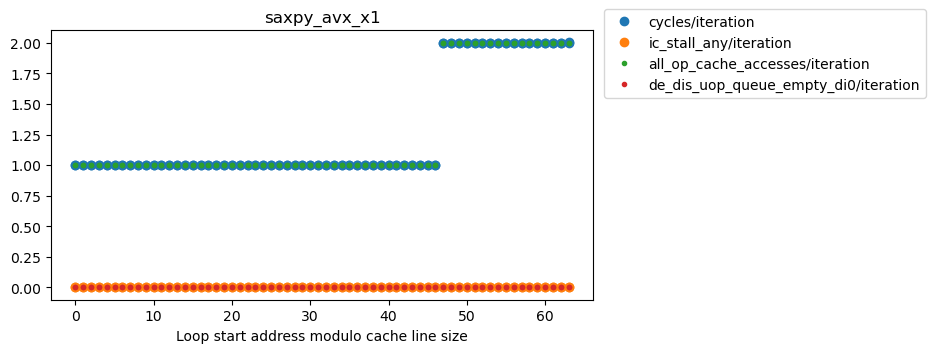

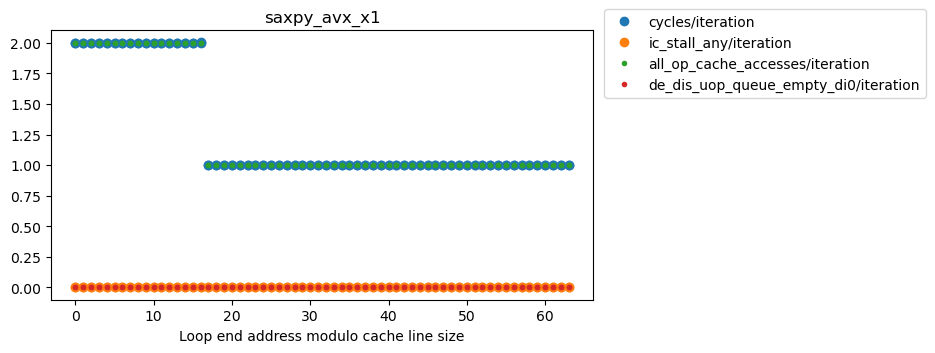

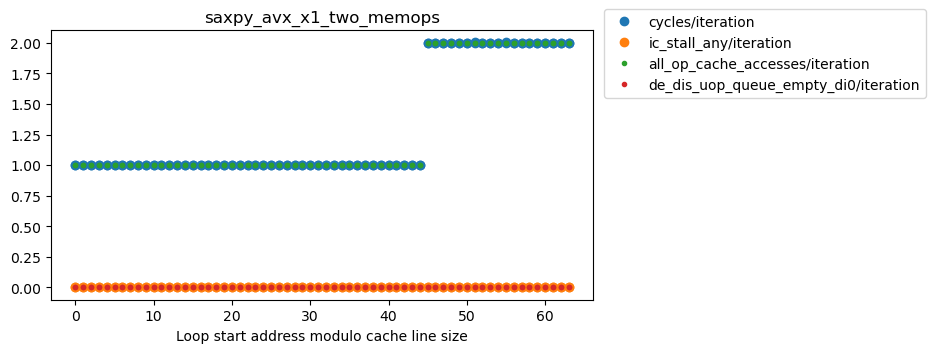

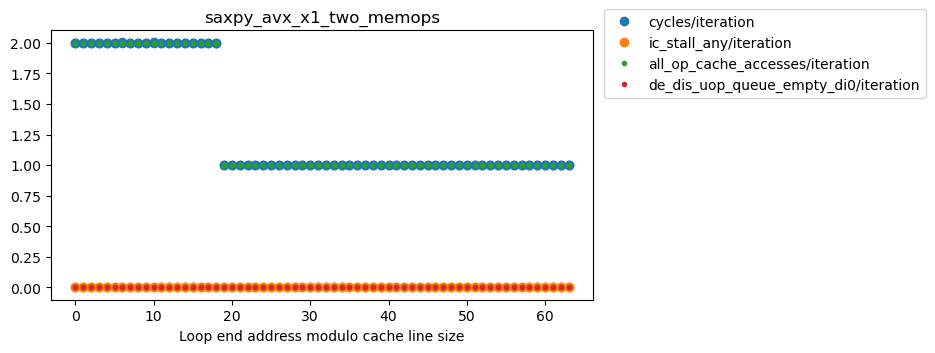

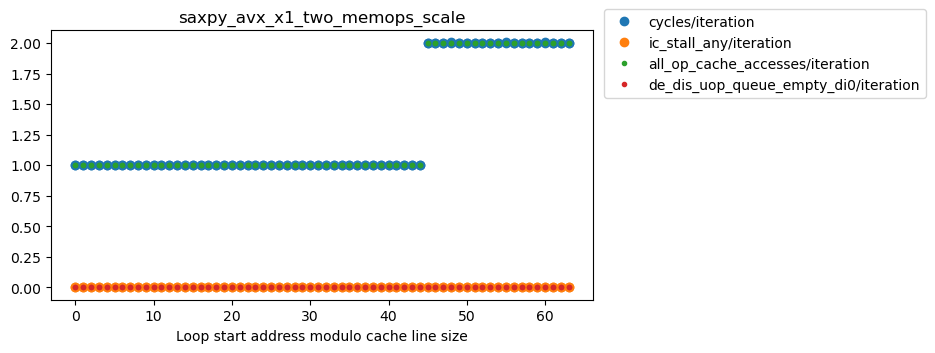

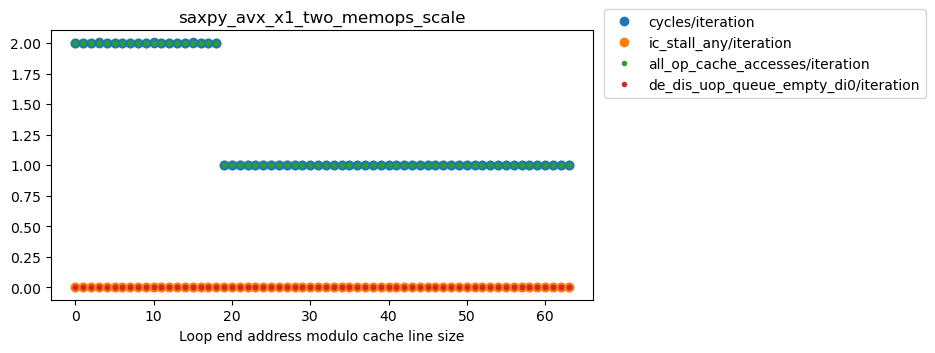

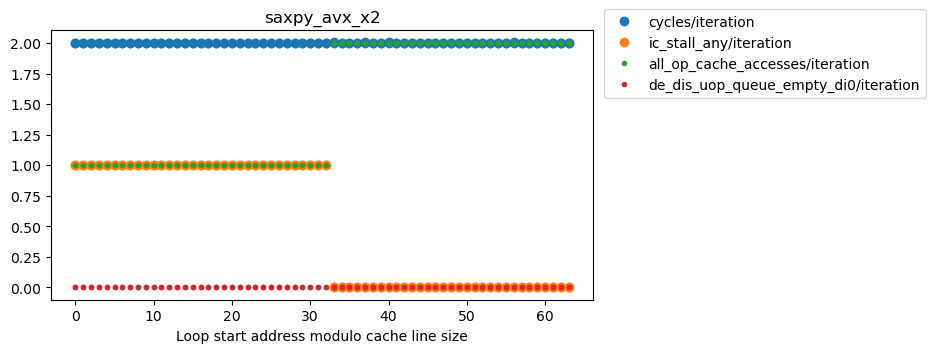

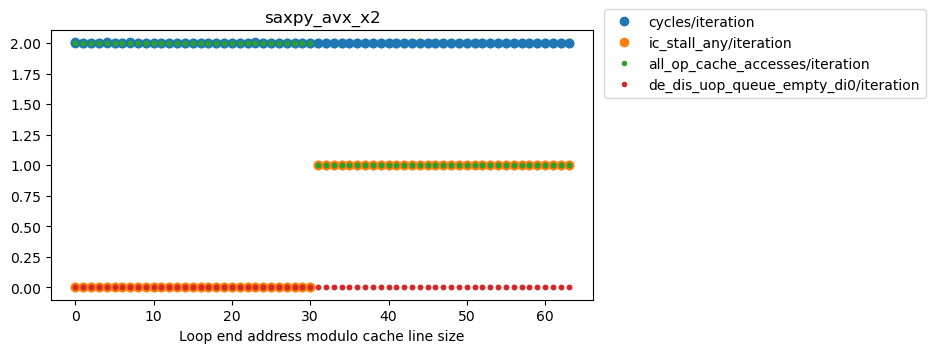

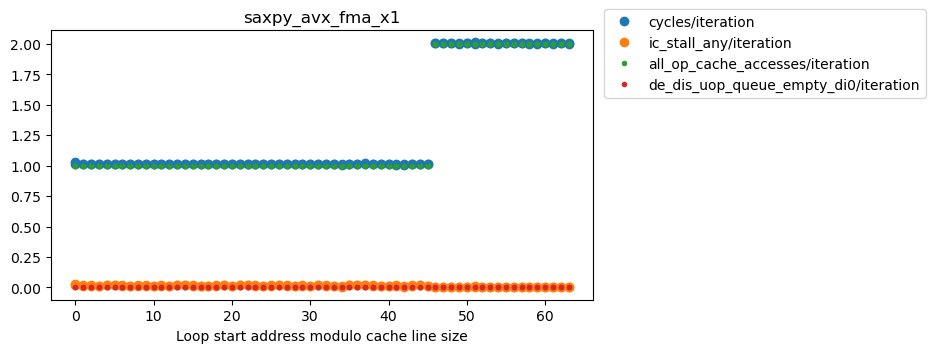

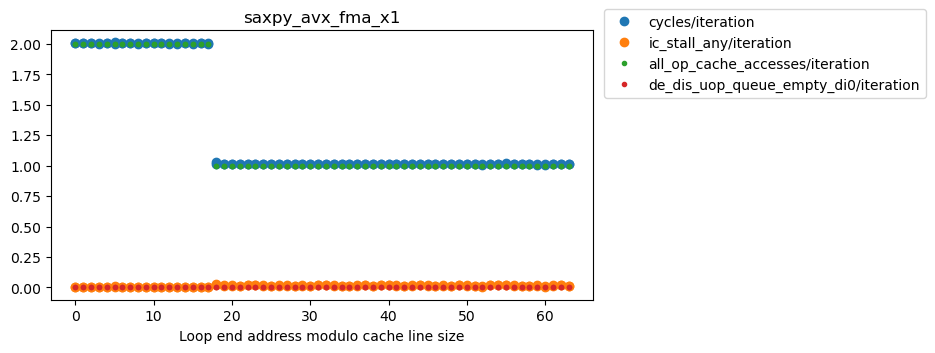

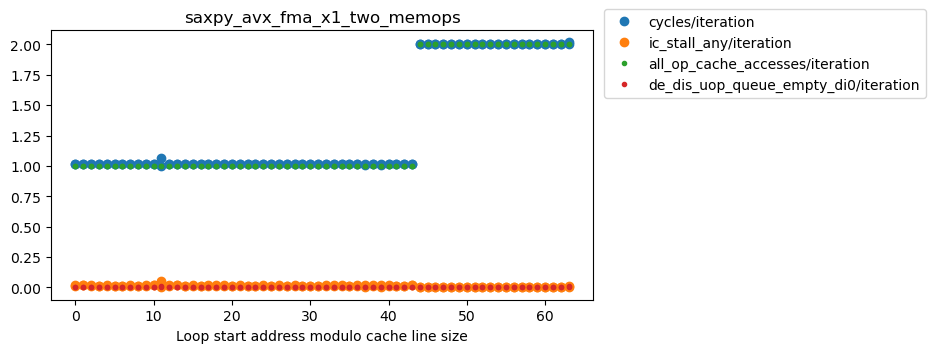

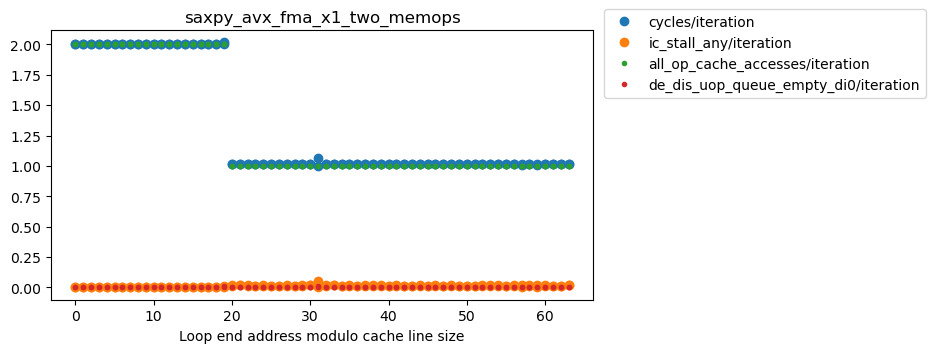

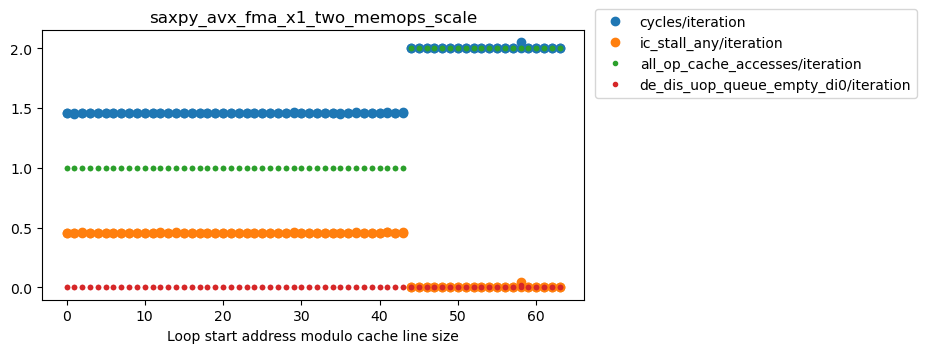

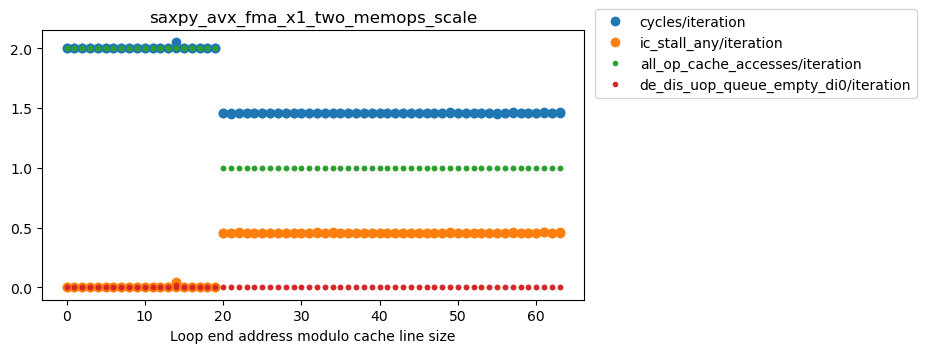

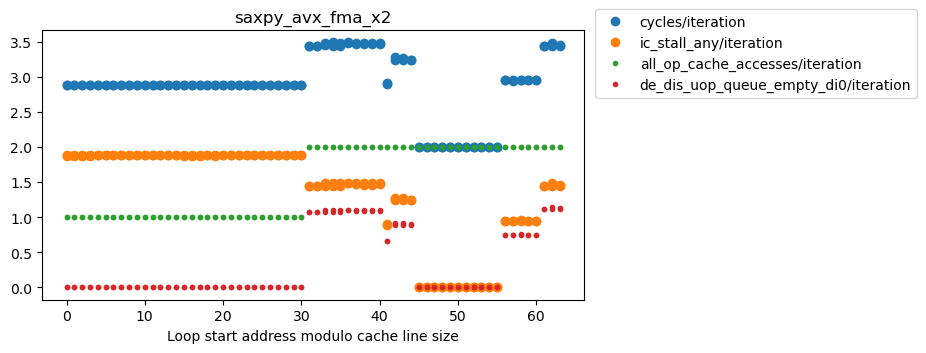

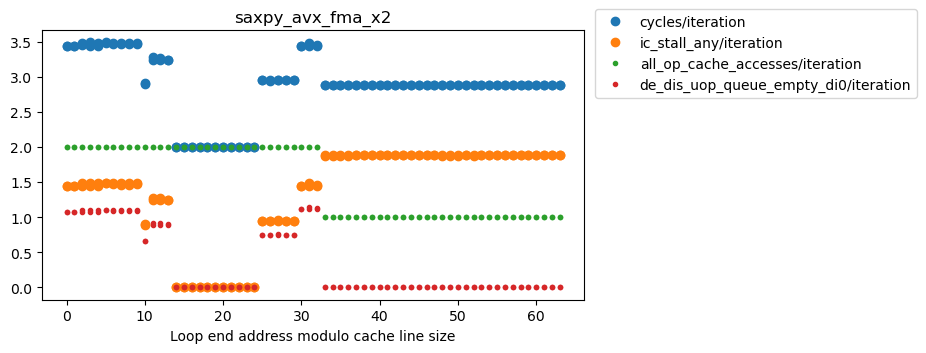

In [4]:
for bench in asm_parameters:
    process(f'{bench}.json')